In [3]:
import findspark
findspark.init()

import pandas as pd
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

C:\Users\spark-3.5.1-bin-hadoop3\python\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [4]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SparkSQL") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions",100)


In [5]:
movieData = pd.read_csv("../resources/movieData.csv", converters={'genres': literal_eval, 'production_countries': literal_eval, 'directors': literal_eval, 'actors': literal_eval})
movieData = movieData.drop(columns=['id', 'title', 'release_decade'])
movieData.head()

,Unnamed: 0,release_year,age_certification,runtime,genres,production_countries,imdb_score,imdb_votes,actors,directors
0,0,1976,R,114,"[drama, crime]",[US],8.2,808582.0,"[Robert De Niro 3748 ACTOR, Jodie Foster 14658...",[Martin Scorsese 3308 DIRECTOR]
1,1,1972,R,109,"[drama, action, thriller, european]",[US],7.7,107673.0,"[Jon Voight 10103 ACTOR, Burt Reynolds 13020 A...",[John Boorman 17727 DIRECTOR]
2,2,1975,PG,91,"[fantasy, action, comedy]",[GB],8.2,534486.0,"[Graham Chapman 11472 ACTOR, John Cleese 1549 ...","[Terry Jones 11475 DIRECTOR, Terry Gilliam 114..."
3,3,1967,0,150,"[war, action]","[GB, US]",7.7,72662.0,"[Lee Marvin 35196 ACTOR, Ernest Borgnine 1050 ...",[Robert Aldrich 1063 DIRECTOR]
4,4,1979,R,94,[comedy],[GB],8.0,395024.0,"[Graham Chapman 11472 ACTOR, John Cleese 1549 ...",[Terry Jones 11475 DIRECTOR]


In [6]:
movieData.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [7]:
movieData[["actors", "directors"]] = movieData[["actors", "directors"]].replace(0, None)
movieData.head()

,id,release_year,age_certification,runtime,genres,production_countries,imdb_score,imdb_votes,actors,directors
0,0,1976,R,114,"[drama, crime]",[US],8.2,808582.0,"[Robert De Niro 3748 ACTOR, Jodie Foster 14658...",[Martin Scorsese 3308 DIRECTOR]
1,1,1972,R,109,"[drama, action, thriller, european]",[US],7.7,107673.0,"[Jon Voight 10103 ACTOR, Burt Reynolds 13020 A...",[John Boorman 17727 DIRECTOR]
2,2,1975,PG,91,"[fantasy, action, comedy]",[GB],8.2,534486.0,"[Graham Chapman 11472 ACTOR, John Cleese 1549 ...","[Terry Jones 11475 DIRECTOR, Terry Gilliam 114..."
3,3,1967,0,150,"[war, action]","[GB, US]",7.7,72662.0,"[Lee Marvin 35196 ACTOR, Ernest Borgnine 1050 ...",[Robert Aldrich 1063 DIRECTOR]
4,4,1979,R,94,[comedy],[GB],8.0,395024.0,"[Graham Chapman 11472 ACTOR, John Cleese 1549 ...",[Terry Jones 11475 DIRECTOR]


In [8]:
movieSpark = spark.createDataFrame(movieData)

movieSpark.show()

+---+------------+-----------------+-------+--------------------+--------------------+----------+----------+--------------------+--------------------+
| id|release_year|age_certification|runtime|              genres|production_countries|imdb_score|imdb_votes|              actors|           directors|
+---+------------+-----------------+-------+--------------------+--------------------+----------+----------+--------------------+--------------------+
|  0|        1976|                R|    114|      [drama, crime]|                [US]|       8.2|  808582.0|[Robert De Niro 3...|[Martin Scorsese ...|
|  1|        1972|                R|    109|[drama, action, t...|                [US]|       7.7|  107673.0|[Jon Voight 10103...|[John Boorman 177...|
|  2|        1975|               PG|     91|[fantasy, action,...|                [GB]|       8.2|  534486.0|[Graham Chapman 1...|[Terry Jones 1147...|
|  3|        1967|                0|    150|       [war, action]|            [GB, US]|       7

In [9]:
movieSpark.createOrReplaceTempView('movie')
movieSpark.write.parquet('movie_parquet', mode='overwrite')
movieParquet = spark.read.parquet('movie_parquet')

In [10]:
movieParquet.createOrReplaceTempView('movieP')

In [11]:
movieGenreEx = spark.sql("""select id, explode(genres) as genre from movieP order by id""")
movieCountryEx = spark.sql("""select id, explode(production_countries) as country from movieP order by id""")
movieActorEx = spark.sql("""select id, explode(actors) as actor from movieP order by id""")
movieDirectorEx = spark.sql("""select id, explode(directors) as director from movieP order by id""")

In [12]:
movieCountryEx.groupBy('country').count().groupby('count').count().sort('count').show(50)

+-----+-----+
|count|count|
+-----+-----+
|    1|   25|
|    2|   14|
|    3|    5|
|    4|    7|
|    5|    3|
|    6|    1|
|    7|    3|
|    8|    2|
|    9|    2|
|   10|    2|
|   11|    1|
|   12|    3|
|   13|    1|
|   15|    2|
|   17|    4|
|   19|    2|
|   20|    1|
|   28|    1|
|   30|    2|
|   31|    1|
|   34|    1|
|   35|    2|
|   40|    1|
|   46|    1|
|   50|    1|
|   53|    1|
|   56|    1|
|   58|    2|
|   61|    2|
|   75|    1|
|   79|    1|
|  100|    1|
|  102|    1|
|  129|    1|
|  141|    1|
|  174|    1|
|  239|    1|
|  552|    1|
| 1374|    1|
+-----+-----+



In [13]:
highCountry = movieCountryEx.groupby('country').count().filter('count > 10').drop('count').rdd.flatMap(lambda x: x).collect()

In [14]:
movieDirectorEx.groupBy('director').count().groupby('count').count().sort('count').show()

+-----+-----+
|count|count|
+-----+-----+
|    1| 2245|
|    2|  286|
|    3|  111|
|    4|   34|
|    5|   18|
|    6|    6|
|    7|    3|
|    8|    2|
|   11|    2|
|   12|    1|
|   14|    2|
|   15|    1|
|   19|    1|
|   20|    1|
+-----+-----+



In [15]:
highDirector = movieDirectorEx.groupBy('director').count().filter('count > 2').drop('count').rdd.flatMap(lambda x: x).collect()

In [16]:
movieActorEx.groupBy('actor').count().groupby('count').count().sort('count').show(50)

+-----+-----+
|count|count|
+-----+-----+
|    1|34534|
|    2| 4890|
|    3| 1555|
|    4|  662|
|    5|  324|
|    6|  169|
|    7|   91|
|    8|   59|
|    9|   34|
|   10|   30|
|   11|   14|
|   12|   10|
|   13|    3|
|   14|    6|
|   15|    2|
|   16|    4|
|   17|    2|
|   18|    5|
|   19|    1|
|   20|    2|
|   22|    1|
|   25|    2|
+-----+-----+



In [17]:
highActor = movieActorEx.groupBy('actor').count().where('count > 3').drop('count').rdd.flatMap(lambda x: x).collect()
highActor

['Christian Bale 4567 ACTOR',
 'Showtaro Morikubo 30774 ACTOR',
 'Ritesh Deshmukh 64747 ACTOR',
 'Eva Green 5310 ACTOR',
 'Eric Bana 7369 ACTOR',
 'Jeff Bridges 6601 ACTOR',
 'Rajendra Gupta 322032 ACTOR',
 'Matt Walsh 17124 ACTOR',
 'Danny Trejo 8711 ACTOR',
 'Terry Crews 160 ACTOR',
 'Idris Elba 1675 ACTOR',
 'Guy Pearce 5080 ACTOR',
 'James Russo 5750 ACTOR',
 'Andy Richter 22676 ACTOR',
 'Laurence Fishburne 5834 ACTOR',
 'Sharman Joshi 91075 ACTOR',
 'Boman Irani 38636 ACTOR',
 'Kimberly Williams-Paisley 5434 ACTOR',
 'Hattie Morahan 590154 ACTOR',
 'Tom Hanks 2718 ACTOR',
 'Lily Collins 15526 ACTOR',
 'David Spade 5146 ACTOR',
 'Donnie Yen 6663 ACTOR',
 'Kareena Kapoor Khan 48004 ACTOR',
 'Andy Samberg 5143 ACTOR',
 'Eric Keenleyside 7115 ACTOR',
 'Adriane Lenox 16724 ACTOR',
 'Rob Schneider 8472 ACTOR',
 'Jorge Garcia 15713 ACTOR',
 'Priyanka Chopra Jonas 12022 ACTOR',
 'Hrithik Roshan 55476 ACTOR',
 'Missi Pyle 6092 ACTOR',
 'Mark Wahlberg 1071 ACTOR',
 'Kevin Corrigan 6693 ACTO

In [18]:
movieActorHigh = movieActorEx.withColumn('actor', F.when(movieActorEx.actor.isin(highActor), movieActorEx.actor) \
                                .otherwise('other'))
movieActorHigh.groupBy('actor').count().groupby('count').count().sort('count').show(50)

+-----+-----+
|count|count|
+-----+-----+
|    4|  662|
|    5|  324|
|    6|  169|
|    7|   91|
|    8|   59|
|    9|   34|
|   10|   30|
|   11|   14|
|   12|   10|
|   13|    3|
|   14|    6|
|   15|    2|
|   16|    4|
|   17|    2|
|   18|    5|
|   19|    1|
|   20|    2|
|   22|    1|
|   25|    2|
|48979|    1|
+-----+-----+



In [19]:
movieCountryHigh = movieCountryEx.withColumn('country', F.when(movieCountryEx.country.isin(highCountry), movieCountryEx.country) \
                                .otherwise('other'))
movieCountryHigh.groupBy('country').count().groupby('count').count().sort('count').show(50)

+-----+-----+
|count|count|
+-----+-----+
|   11|    1|
|   12|    3|
|   13|    1|
|   15|    2|
|   17|    4|
|   19|    2|
|   20|    1|
|   28|    1|
|   30|    2|
|   31|    1|
|   34|    1|
|   35|    2|
|   40|    1|
|   46|    1|
|   50|    1|
|   53|    1|
|   56|    1|
|   58|    2|
|   61|    2|
|   75|    1|
|   79|    1|
|  100|    1|
|  102|    1|
|  129|    1|
|  141|    1|
|  174|    1|
|  192|    1|
|  239|    1|
|  552|    1|
| 1374|    1|
+-----+-----+



In [22]:
movieDirectorHigh = movieDirectorEx.withColumn('director', F.when(movieDirectorEx.director.isin(highDirector), movieDirectorEx.director) \
                                .otherwise("other"))
movieDirectorHigh.groupBy('director').count().groupby('count').count().sort('count').show(50)

+-----+-----+
|count|count|
+-----+-----+
|    3|  111|
|    4|   34|
|    5|   18|
|    6|    6|
|    7|    3|
|    8|    2|
|   11|    2|
|   12|    1|
|   14|    2|
|   15|    1|
|   19|    1|
|   20|    1|
| 2817|    1|
+-----+-----+



In [25]:
movieDirectorHigh.createOrReplaceTempView('directors')
movieActorHigh.createOrReplaceTempView('actors')
movieCountryHigh.createOrReplaceTempView('countries')
movieGenreEx.createOrReplaceTempView('genres')

In [21]:
spark.sql("""select * from movieP""").show()

+---+------------+-----------------+-------+--------------------+--------------------+----------+----------+--------------------+--------------------+
| id|release_year|age_certification|runtime|              genres|production_countries|imdb_score|imdb_votes|              actors|           directors|
+---+------------+-----------------+-------+--------------------+--------------------+----------+----------+--------------------+--------------------+
|142|        1997|                0|    136|[drama, history, ...|            [FR, EG]|       7.1|    2857.0|[Nour El-Sherif 3...|                NULL|
|143|        1996|                0|     88|             [drama]|    [PS, US, FR, DE]|       6.9|     733.0|[Elia Suleiman 74...|[Elia Suleiman 74...|
|144|        1995|                G|    165|[comedy, drama, a...|                [IN]|       7.6|    3056.0|[Rajinikanth 6443...|[K. S. Ravikumar ...|
|145|        1998|                0|    175|[comedy, drama, r...|                [IN]|       6

In [59]:
movieDirEx = movieData.explode('directors')
showDirEx = showData.explode('directors')
replaceDirMovie = [director for director in movieDirEx["directors"].value_counts().index if movieDirEx["directors"].value_counts()[director] < 2]
replaceDirShow = [director for director in showDirEx["directors"].value_counts().index if showDirEx["directors"].value_counts()[director] < 2]
for director in replaceDirMovie:
    movieDirEx['directors'] = movieDirEx['directors'].replace(director, "other")
    showDirEx['directors'] = showDirEx['directors'].replace(director, "other")

movieDirEx['directors'].value_counts()


directors
other                               2245
Raúl Campos 211560 DIRECTOR           20
Jan Suter 590250 DIRECTOR             19
Ryan Polito 159658 DIRECTOR           15
Jay Karas 66544 DIRECTOR              14
                                    ... 
Aziz Ansari 22297 DIRECTOR             2
Jerrold Tarog 133288 DIRECTOR          2
Marcus Nispel 25429 DIRECTOR           2
Hannah Fidell 56653 DIRECTOR           2
Veronica Velasco 134688 DIRECTOR       2
Name: count, Length: 469, dtype: int64

In [8]:
movieDummies = ps.get_dummies(movieEx, columns=['release_year', 'age_certification', 'genres', 'production_countries', 'directors'])
movieDummies.head()

runtime  imdb_score  imdb_votes  release_year_1954  release_year_1956  release_year_1958  release_year_1959  release_year_1960  release_year_1961  release_year_1963  release_year_1966  release_year_1967  release_year_1969  release_year_1971  release_year_1972  release_year_1973  release_year_1974  release_year_1975  release_year_1976  release_year_1977  release_year_1978  release_year_1979  release_year_1980  release_year_1981  release_year_1982  release_year_1983  release_year_1984  release_year_1985  release_year_1986  release_year_1987  release_year_1988  release_year_1989  release_year_1990  release_year_1991  release_year_1992  release_year_1993  release_year_1994  release_year_1995  release_year_1996  release_year_1997  release_year_1998  release_year_1999  release_year_2000  release_year_2001  release_year_2002  release_year_2003  release_year_2004  release_year_2005  release_year_2006  release_year_2007  release_year_2008  release_year_2009  release_year_2010  release_year_2011  release_year_2012  release_year_2013  release_year_2014  release_year_2015  release_year_2016  release_year_2017  release_year_2018  release_year_2019  release_year_2020  release_year_2021  release_year_2022  age_certification_0  age_certification_G  age_certification_NC-17  age_certification_PG  age_certification_PG-13  age_certification_R  genres_action  genres_animation  genres_comedy  genres_crime  genres_documentation  genres_drama  genres_european  genres_family  genres_fantasy  genres_history  genres_horror  genres_music  genres_reality  genres_romance  genres_scifi  genres_sport  genres_thriller  genres_war  genres_western  production_countries_AE  production_countries_AF  production_countries_AL  production_countries_AO  production_countries_AR  production_countries_AT  production_countries_AU  production_countries_BD  production_countries_BE  production_countries_BF  production_countries_BG  production_countries_BR  production_countries_BS  production_countries_BT  production_countries_CA  production_countries_CD  production_countries_CH  production_countries_CL  production_countries_CM  production_countries_CN  production_countries_CO  production_countries_CU  production_countries_CY  production_countries_CZ  production_countries_DE  production_countries_DK  production_countries_DZ  production_countries_EG  production_countries_ES  production_countries_FI  production_countries_FO  production_countries_FR  production_countries_GB  production_countries_GE  production_countries_GH  production_countries_GL  production_countries_GR  production_countries_GT  production_countries_HK  production_countries_HU  production_countries_ID  production_countries_IE  production_countries_IL  production_countries_IN  production_countries_IQ  production_countries_IR  production_countries_IS  production_countries_IT  production_countries_JO  production_countries_JP  production_countries_KE  production_countries_KG  production_countries_KH  production_countries_KR  production_countries_KW  production_countries_LB  production_countries_LK  production_countries_LT  production_countries_LU  production_countries_Lebanon  production_countries_MA  production_countries_MC  production_countries_MT  production_countries_MU  production_countries_MW  production_countries_MX  production_countries_MY  production_countries_NG  production_countries_NL  production_countries_NO  production_countries_NP  production_countries_NZ  production_countries_PE  production_countries_PH  production_countries_PK  production_countries_PL  production_countries_PR  production_countries_PS  production_countries_PT  production_countries_PY  production_countries_QA  production_countries_RO  production_countries_RS  production_countries_RU  production_countries_SA  production_countries_SE  production_countries_SG  production_countries_SN  production_countries_SU  production_countries_SY  production_countries_TH  production_countries_TN  production_countries_TR  production_countries_TW  pro

In [7]:
showDummies = pd.get_dummies(showEx, columns=['release_decade', 'age_certification', 'genres', 'production_countries', 'seasons'])
showDummies

,runtime,imdb_score,imdb_votes,release_decade_00s,release_decade_10s,release_decade_20s,release_decade_60s,release_decade_70s,release_decade_80s,release_decade_90s,...,seasons_19.0,seasons_20.0,seasons_21.0,seasons_24.0,seasons_25.0,seasons_29.0,seasons_32.0,seasons_37.0,seasons_39.0,seasons_42.0
0,30,8.8,73424.0,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,30,8.8,73424.0,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,43,8.1,2151.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,24,8.9,308824.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,51,6.9,34115.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937,37,5.1,738.0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1937,37,5.1,738.0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1938,7,7.8,18.0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1938,7,7.8,18.0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
yShowScore = showDummies['imdb_score']
yMovieScore = movieDummies['imdb_score']
yShowVotes = showDummies['imdb_votes']
yMovieVotes = movieDummies['imdb_votes']

In [9]:
XShowScore = showDummies.drop(columns='imdb_score')
XMovieScore = movieDummies.drop(columns='imdb_score')
XShowVotes = showDummies.drop(columns='imdb_votes')
XMovieVotes = movieDummies.drop(columns='imdb_votes')

In [10]:
# Movie Score Train, Test, Scale
XtrainMS, XtestMS, ytrainMS, ytestMS = train_test_split(XMovieScore, yMovieScore, random_state=1)

scaler = StandardScaler()

XscalerMS = scaler.fit(XtrainMS)

XtrainScaledMS = XscalerMS.transform(XtrainMS)
XtestScaledMS = XscalerMS.transform(XtestMS)

In [11]:
tf.keras.backend.clear_session()
nn = tf.keras.models.Sequential()


nn.add(tf.keras.layers.Dense(units=30, activation="relu", input_dim=2767))

nn.add(tf.keras.layers.Dense(units=30, activation="relu"))

nn.add(tf.keras.layers.Dense(units=30, activation="relu"))

nn.add(tf.keras.layers.Dense(units=30, activation="relu"))

nn.add(tf.keras.layers.Dense(units=30, activation="relu"))

nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                83040     
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 86,791
Trainable params: 86,791
Non-traina

In [12]:
nn.compile(loss='mean_absolute_error', optimizer="adam")

In [13]:
fit_model = nn.fit(XtrainScaledMS, ytrainMS, epochs=50)

Epoch 1/50
282/282 [==============================] - 8s 26ms/step - loss: 1.6677
Epoch 2/50
282/282 [==============================] - 8s 27ms/step - loss: 0.5937
Epoch 3/50
282/282 [==============================] - 8s 28ms/step - loss: 0.4529
Epoch 4/50
282/282 [==============================] - 8s 27ms/step - loss: 0.4095
Epoch 5/50
282/282 [==============================] - 8s 27ms/step - loss: 0.3817
Epoch 6/50
282/282 [==============================] - 7s 27ms/step - loss: 0.3671
Epoch 7/50
282/282 [==============================] - 8s 27ms/step - loss: 0.3395
Epoch 8/50
282/282 [==============================] - 8s 28ms/step - loss: 0.3280
Epoch 9/50
282/282 [==============================] - 7s 26ms/step - loss: 0.3238
Epoch 10/50
282/282 [==============================] - 7s 26ms/step - loss: 0.3037
Epoch 11/50
282/282 [==============================] - 8s 27ms/step - loss: 0.3125
Epoch 12/50
282/282 [==============================] - 7s 25ms/step - loss: 0.2876
Epoch 13/50
2

In [14]:
model_loss = nn.evaluate(XtestScaledMS, ytestMS, verbose=2)
print(model_loss)

94/94 - 3s - loss: 0.2744 - 3s/epoch - 27ms/step
0.27442634105682373


94/94 [==============================] - 3s 26ms/step


Text(0.5, 1.0, 'Large DNN (2767 Features)')

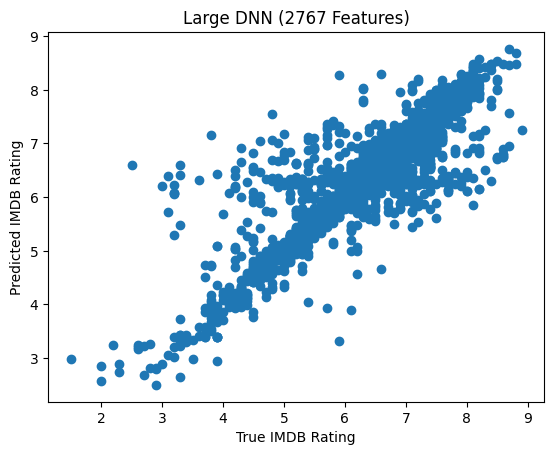

In [15]:
testPredictions = nn.predict(XtestScaledMS).flatten()
plt.scatter(ytestMS, testPredictions)
plt.xlabel('True IMDB Rating')
plt.ylabel('Predicted IMDB Rating')
plt.title('Large DNN (2767 Features)')